In [2]:
import os
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from PIL import Image
import shutil
from tqdm import tqdm

# Path to colon_aca
colon_aca_path = r"C:\Users\bhuva\Downloads\colon cancer detection\LC25000\Train and Validation Set\colon_aca"

# Target directory to save stage-wise images
output_base = r"C:\Users\bhuva\Downloads\colon cancer detection\LC25000\staged_colon_aca"
os.makedirs(output_base, exist_ok=True)

# Load and process images
features = []
image_paths = []

print("Extracting features...")
for fname in tqdm(os.listdir(colon_aca_path)):
    if fname.endswith(".jpeg") or fname.endswith(".jpg") or fname.endswith(".png"):
        path = os.path.join(colon_aca_path, fname)
        try:
            img = Image.open(path).convert("L").resize((64, 64))  # grayscale
            img_array = np.array(img).flatten()
            features.append(img_array)
            image_paths.append(path)
        except:
            continue

features = np.array(features)

# Normalize
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

# KMeans
kmeans = KMeans(n_clusters=4, random_state=42)
labels = kmeans.fit_predict(features_scaled)

# Move files to stage folders
print("Organizing images into stages...")
for i, label in enumerate(labels):
    stage_folder = os.path.join(output_base, f"stage_{label+1}")
    os.makedirs(stage_folder, exist_ok=True)
    shutil.copy(image_paths[i], os.path.join(stage_folder, os.path.basename(image_paths[i])))

print("Done! Images split into stage_1 to stage_4.")


Extracting features...


100%|██████████████████████████████████████████████████████████████████████████████| 4500/4500 [01:09<00:00, 64.46it/s]


Organizing images into stages...
Done! Images split into stage_1 to stage_4.


Found 7201 images belonging to 5 classes.
Found 1799 images belonging to 5 classes.


C:\Users\bhuva\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\bhuva\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15
226/226 ━━━━━━━━━━━━━━━━━━━━ 238s 1s/step - accuracy: 0.4519 - loss: 3.8127 - val_accuracy: 0.5003 - val_loss: 1.2297
Epoch 2/15
226/226 ━━━━━━━━━━━━━━━━━━━━ 148s 654ms/step - accuracy: 0.5038 - loss: 1.2197 - val_accuracy: 0.5081 - val_loss: 1.1526
Epoch 3/15
226/226 ━━━━━━━━━━━━━━━━━━━━ 149s 657ms/step - accuracy: 0.5811 - loss: 1.0244 - val_accuracy: 0.6137 - val_loss: 1.0299
Epoch 4/15
226/226 ━━━━━━━━━━━━━━━━━━━━ 150s 665ms/step - accuracy: 0.7357 - loss: 0.7180 - val_accuracy: 0.6776 - val_loss: 0.8185
Epoch 5/15
226/226 ━━━━━━━━━━━━━━━━━━━━ 146s 646ms/step - accuracy: 0.8551 - loss: 0.4172 - val_accuracy: 0.6937 - val_loss: 0.8727
Epoch 6/15
226/226 ━━━━━━━━━━━━━━━━━━━━ 146s 647ms/step - accuracy: 0.9136 - loss: 0.2646 - val_accuracy: 0.6837 - val_loss: 1.0136
Epoch 7/15
226/226 ━━━━━━━━━━━━━━━━━━━━ 146s 645ms/step - accuracy: 0.9517 - loss: 0.1549 - val_accuracy: 0.7021 - val_loss: 1.1210
Epoch 8/15
226/226 ━━━━━━━━━━━━━━━━━━━━ 146s 647ms/step - accuracy: 0.9721 - lo

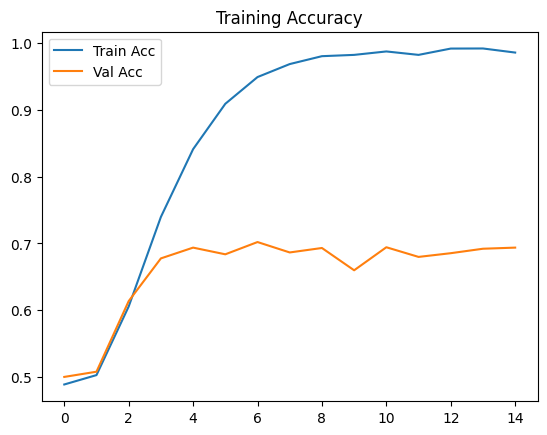

In [3]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
import matplotlib.pyplot as plt

# Path
dataset_path = r"C:\Users\bhuva\Downloads\colon cancer detection\LC25000\Final_Dataset"

# Image generators
datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

train_gen = datagen.flow_from_directory(
    dataset_path,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='training'
)

val_gen = datagen.flow_from_directory(
    dataset_path,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='validation'
)

# Simple CNN (can replace with VGG or ResNet)
model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(224,224,3)),
    MaxPooling2D(2,2),
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(5, activation='softmax')  # 5 classes
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train
history = model.fit(train_gen, epochs=15, validation_data=val_gen)

# Save
model.save("colorectal_staging_model.h5")

# Plot
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Training Accuracy')
plt.legend()
plt.show()


In [10]:
import tkinter as tk
from tkinter import filedialog, scrolledtext
from PIL import Image, ImageTk
import numpy as np
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# Load model
model = load_model("colorectal_staging_model.h5")

# Class labels
class_labels = ["No Cancer", "Stage 1", "Stage 2", "Stage 3", "Stage 4"]

# Explanations
explanations = {
    "No Cancer": "No signs of cancer detected in the colon tissue. Regular checkups are still recommended.",
    "Stage 1": "Small tumor in the colon wall. High recovery chance. Usually treatable with surgery.",
    "Stage 2": "Tumor has grown through colon wall but not reached lymph nodes. May require chemo post-surgery.",
    "Stage 3": "Cancer has spread to nearby lymph nodes. Needs surgery and chemotherapy.",
    "Stage 4": "Cancer has spread to distant organs like liver or lungs. Focus is on control and quality of life."
}

# Doctor recommendations
doctor_recommendations = {
    "No Cancer": "🩺 Recommendation: Maintain a healthy lifestyle. Screening every 5–10 years.",
    "Stage 1": "🩺 Recommendation: Surgical removal is typically effective. Monitor regularly.",
    "Stage 2": "🩺 Recommendation: Surgery followed by chemotherapy may be required.",
    "Stage 3": "🩺 Recommendation: Intensive treatment including surgery and chemotherapy. Regular imaging.",
    "Stage 4": "🩺 Recommendation: Advanced care with systemic therapy. Palliative support recommended."
}

# Fade-in animation
def fade_in_text(widget, text, delay=30):
    widget.config(text="")
    def _fade(i=0):
        if i <= len(text):
            widget.config(text=text[:i])
            widget.after(delay, lambda: _fade(i + 1))
    _fade()

# Prediction function
def predict_image():
    file_path = filedialog.askopenfilename()
    if file_path:
        img = load_img(file_path, target_size=(224, 224))
        img_array = img_to_array(img) / 255.0
        img_array = np.expand_dims(img_array, axis=0)
        pred = model.predict(img_array)
        class_index = np.argmax(pred[0])
        result = class_labels[class_index]

        # Update GUI with animation
        fade_in_text(result_label, f"Prediction: {result}")
        fade_in_text(explanation_label, f"Explanation: {explanations[result]}")
        fade_in_text(recommendation_label, f"{doctor_recommendations[result]}")

        # Show image
        img_disp = Image.open(file_path).resize((220, 220))
        img_tk = ImageTk.PhotoImage(img_disp)
        image_label.config(image=img_tk)
        image_label.image = img_tk

# Main GUI
root = tk.Tk()
root.title("Colorectal Cancer Stage Detector")
root.geometry("700x720")
root.configure(bg="#e8f0fe")

title = tk.Label(root, text="Colorectal Cancer Stage Detector", font=("Helvetica", 20, "bold"), bg="#e8f0fe", fg="#2c3e50")
title.pack(pady=20)

upload_btn = tk.Button(root, text="Upload Image", command=predict_image, font=("Helvetica", 14), bg="#3498db", fg="white", padx=20, pady=5)
upload_btn.pack(pady=10)

image_label = tk.Label(root, bg="#e8f0fe")
image_label.pack(pady=10)

result_label = tk.Label(root, text="", bg="#e8f0fe", font=("Helvetica", 16, "bold"), fg="#e74c3c")
result_label.pack(pady=5)

explanation_label = tk.Label(root, text="", bg="#e8f0fe", font=("Helvetica", 12), wraplength=600, justify="left")
explanation_label.pack(padx=20, pady=10)

recommendation_label = tk.Label(root, text="", bg="#e8f0fe", font=("Helvetica", 12), wraplength=600, justify="left", fg="#2d3436")
recommendation_label.pack(padx=20, pady=10)

footer = tk.Label(root, text="Powered by Deep Learning | Presentation Mode", bg="#e8f0fe", fg="gray", font=("Helvetica", 10))
footer.pack(side="bottom", pady=10)

root.mainloop()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


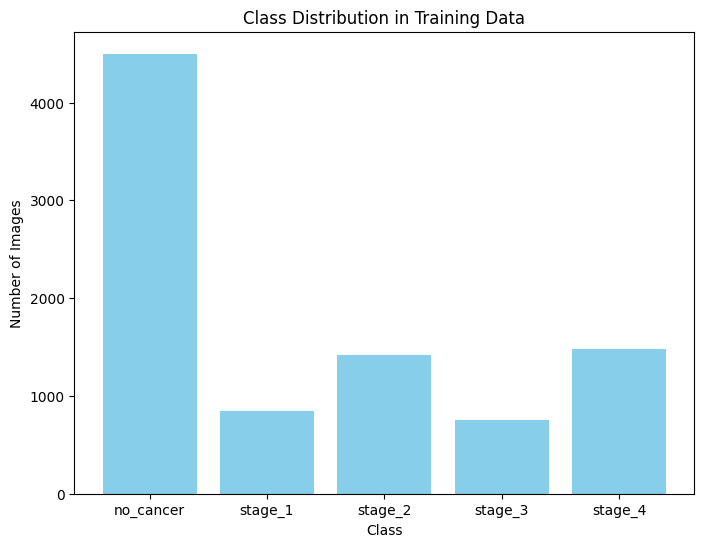

In [14]:
import os
from collections import Counter

train_dir = r"C:\Users\bhuva\Downloads\colon cancer detection\LC25000\Final_Dataset"
class_counts = {cls: len(os.listdir(os.path.join(train_dir, cls))) for cls in os.listdir(train_dir)}

plt.figure(figsize=(8, 6))
plt.bar(class_counts.keys(), class_counts.values(), color='skyblue')
plt.title("Class Distribution in Training Data")
plt.xlabel("Class")
plt.ylabel("Number of Images")
plt.savefig("class_distribution.png")
plt.show()
